## SET UP

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, Layer, Reshape, Input, Permute, Attention
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LayerNormalization, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from keras import regularizers
from keras.models import Model
import keras
from tensorflow.keras.optimizers import Adam
from keras import backend as K
%matplotlib inline

## DATA AGGREGATION

In [3]:
review_dtmtb = pd.read_csv('reviewData_dtmtb.csv')
review_dtdl = pd.read_csv('reviewData_dtdl.csv')
review_tbkts_pks = pd.read_csv('reviewData_tbkts_pks.csv')

NameError: name 'pd' is not defined

In [4]:
review_data = pd.concat([review_dtmtb, review_dtdl, review_tbkts_pks])

In [4]:
review_data.head()

,id,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at
0,17206712,Cực kì hài lòng,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",0,20468199,5,1658815564,NaN,NaN
1,17022830,Cực kì hài lòng,giao hàng đúng thời. điện thoại giao đúng mẫu....,3,21886251,5,1657513127,NaN,NaN
2,16990209,Cực kì hài lòng,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,5,14674088,5,1657279289,NaN,NaN
3,16618308,Cực kì hài lòng,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1,14923716,5,1654645068,NaN,NaN
4,17056290,Cực kì hài lòng,cho tiki trading shop 5 sao!shop uy tín! giao ...,0,7966673,5,1657721825,NaN,NaN


In [5]:
review_data.value_counts('rating')

rating
5    92711
4    15936
1     7053
3     4882
2     2319
dtype: int64

In [6]:
review_data['content'].isna().sum()

45167

In [7]:
review_data.dropna(subset=['content'], inplace=True)

In [8]:
review_data['content'].isna().sum()

0

In [9]:
review_dtmtb.value_counts('title')

title
Cực kì hài lòng                                      16757
Hài lòng                                              2057
Rất không hài lòng                                     570
Bình thường                                            400
Không hài lòng                                         193
                                                     ...  
The perfect device to read on the go                     1
Thích                                                   1
Thông tin hàng không đúng                                1
Thất vọng về service giao 2h và hình thức đổi/hủy        1
10/10 về dịch vụ và sản phẩm                             1
Length: 480, dtype: int64

In [10]:
review_data.value_counts('rating')

rating
5    54361
4     9663
1     6990
3     4427
2     2293
dtype: int64

In [11]:
review_data['rating_class'] = review_data['rating'].apply(lambda x: 1 if x>3 else 0 if x==3 else -1)

In [12]:
review_data['rating_class'].value_counts()

 1    64024
-1     9283
 0     4427
Name: rating_class, dtype: int64

In [13]:
rating_data = review_data[['content','rating_class']]
rating_data = rating_data.rename(columns={'rating_class':"class"})
rating_data

,content,class
0,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",1
1,giao hàng đúng thời. điện thoại giao đúng mẫu....,1
2,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,1
3,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1
4,cho tiki trading shop 5 sao!shop uy tín! giao ...,1
...,...,...
41460,cực kỳ hài lòng,1
41461,"Sạc pin chỉ full 88%, nhờ shop tư vấn",-1
41462,nhìn rất ok.,1
41463,Giao hang nhah hang dung ok,1


In [14]:
data_train, data_test  = train_test_split(rating_data, test_size=0.2)

In [15]:
data_train.value_counts("class")

class
 1    51175
-1     7440
 0     3572
dtype: int64

In [16]:
data_test.value_counts("class")

class
 1    12849
-1     1843
 0      855
dtype: int64

In [19]:
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

## DATA PREPARATION

In [2]:
data_train = pd.read_csv('data_train.csv');
data_test = pd.read_csv('data_test.csv');

In [3]:

data_train_1 = data_train[data_train['class'] == 1]
data_train_0 = data_train[data_train['class'] == 0]
data_train_n1 = data_train[data_train['class'] == -1]

data_train_1 = resample(data_train_1, replace=False, n_samples=3000, random_state=1)
data_train_0 = resample(data_train_0, replace=False, n_samples=3000, random_state=2)
data_train_n1 = resample(data_train_n1, replace=False, n_samples=3000, random_state=3)

data_train = pd.concat([data_train_1, data_train_0, data_train_n1])

In [4]:
data_train.value_counts('class')

class
-1    3000
 0    3000
 1    3000
dtype: int64

In [5]:
labels = data_train.iloc[:,1].values
reviews = data_train.iloc[:,0].values
encoded_labels = []
for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label ==0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [6]:
reviews_processed = []
unlabeld_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)
    
print(reviews[0])
print(reviews_processed[0])

Khá hài lòng
Khá hài lòng


In [7]:
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

print(word_reviews[0])

['khá', 'hài_lòng']


In [8]:
EMBEDDING_DIM = 400 #how big is each word vector
MAX_VOCAB_SIZE = 10000 #how many unique words to use
MAX_SEQUENCE_LENGTH = 300 #max number of words in a comment to use

In [9]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, lower = True, char_level = False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [10]:
data = pad_sequences(sequences_train, maxlen = MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [11]:
sub_data = data[:2000]
sub_labels = labels[:2000]

In [12]:
sub_data.shape

(2000, 300)

In [13]:
print('Shape of X train and X validation tensor', data.shape)
print('Shape of label train and validation tensor', labels.shape)

Shape of X train and X validation tensor (9000, 300)
Shape of label train and validation tensor (9000, 3)


In [14]:
vocabulary_size = min(len(word_index) +1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Test data preparation

In [15]:
# data_test.value_counts('class')

data_test = pd.read_csv('data_test.csv');

In [16]:
# data_test_1 = data_test[data_test['class'] == 1]
# data_test_0 = data_test[data_test['class'] == 0]
# data_test_n1 = data_test[data_test['class'] == -1]

# data_test_1 = resample(data_test_1, replace=False, n_samples=1000, random_state=1)
# data_test_0 = resample(data_test_0, replace=False, n_samples=855, random_state=2)
# data_test_n1 = resample(data_test_n1, replace=False, n_samples=1000, random_state=3)

# data_test = pd.concat([data_test_1, data_test_0, data_test_n1])

In [17]:
labels_test = data_test.iloc[:, 1].values
reviews_test = data_test.iloc[:, 0].values
encoded_labels_test = []
for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test ==0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])
        
encoded_labels_test = np.array(encoded_labels_test)

In [18]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [19]:
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [20]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen = MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [21]:
print('Shape of X train and X validation tencor: ', data_test.shape)
print('Shape of label train and X validation tencor: ', labels_test.shape)

Shape of X train and X validation tencor:  (15547, 300)
Shape of label train and X validation tencor:  (15547, 3)


In [22]:
sub_data_test = data_test[:500]
sub_labels_test = labels_test[:500]

## LSTM

In [23]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM.add(LSTM(128, dropout = 0.1, return_sequences = False))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [24]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 400)          4000000   
                                                                 
 lstm (LSTM)                 (None, 128)               270848    
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 4,272,171
Trainable params: 4,272,171
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0.1, patience = 4, verbose = 1)
callbacks_list = [early_stopping]

In [26]:
%%time
history = model_LSTM.fit(data, labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 127s 3s/step - loss: 0.9682 - acc: 0.5081 - val_loss: 0.6125 - val_acc: 0.7621
Epoch 2/100
36/36 [==============================] - 120s 3s/step - loss: 0.6835 - acc: 0.6936 - val_loss: 0.6821 - val_acc: 0.7445
Epoch 3/100
36/36 [==============================] - 126s 4s/step - loss: 0.5414 - acc: 0.7790 - val_loss: 0.5669 - val_acc: 0.7803
Epoch 4/100
36/36 [==============================] - 121s 3s/step - loss: 0.4419 - acc: 0.8312 - val_loss: 0.6620 - val_acc: 0.7438
Epoch 5/100
36/36 [==============================] - 121s 3s/step - loss: 0.3604 - acc: 0.8703 - val_loss: 0.7023 - val_acc: 0.7565
Epoch 6/100
36/36 [==============================] - 119s 3s/step - loss: 0.3140 - acc: 0.8871 - val_loss: 0.6356 - val_acc: 0.7878
Epoch 7/100
36/36 [==============================] - 128s 4s/step - loss: 0.2805 - acc: 0.8981 - val_loss: 0.8488 - val_acc: 0.7230
Epoch 8/100
36/36 [==============================] - 136s 4s/step - loss: 0.

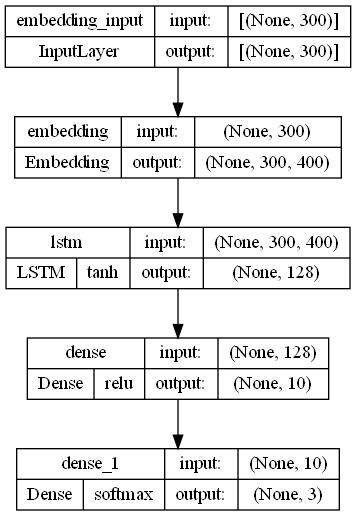

In [27]:
tf.keras.utils.plot_model(model_LSTM, to_file='model_LSTM.png', show_shapes=True, show_layer_activations=True)

In [28]:
score = model_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 61s 125ms/step - loss: 0.9216 - acc: 0.7659
loss: 0.92
acc: 76.59%


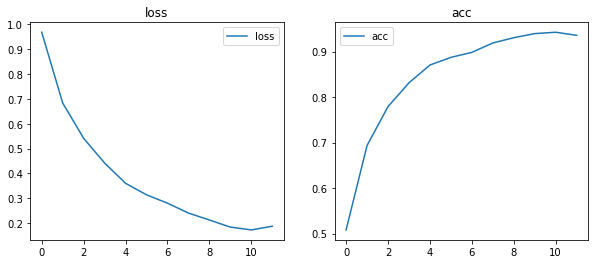

In [29]:
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1,2, figsize = (10, 4))
    hist = history.history
    for ax, metric in zip(axs, ["loss", "acc"]):
        ax.plot(hist[metric])
        ax.legend([metric])
        ax.set_title(metric)
    plt.style.use('default')
    
plot_loss_accuracy(history)

In [73]:
prediction = model_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=1
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 380ms/step
Vấn đề lớn nhất là nó dày quá a~ to, không thon gọn tinh tế như những mẫu khác, màu trắng nữa, dễ dơ. Còn lại thì okie nha.
Tích cực
Bình thường


In [31]:
preds = model_LSTM.predict(data_test)


486/486 [==============================] - 58s 120ms/step


In [32]:
test_class = np.argmax(labels_test, axis = 1)
preds_class = np.argmax(preds, axis = 1)


In [33]:
f1_score(test_class, preds_class, average=None)

array([0.64505597, 0.25397696, 0.86891192])

## LSTM Attention

In [36]:
sequence_length = sub_data.shape[1]
drop = 0.1

inputs = Input(shape = (sequence_length,))
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix])(inputs)
bilstm = LSTM(128, return_sequences = True)(embedding)
attention_layer = attention()(bilstm)
output = Dense(units = 3, activation = 'softmax')(attention_layer)

model_lstm_att = Model(inputs, output)

In [37]:
# Retrieve the config
config = model_lstm_att.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": attention}
with keras.utils.custom_object_scope(custom_objects):
    model_lstm_att = keras.Model.from_config(config)
    
model_lstm_att.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
tf.keras.utils.plot_model(model_lstm_att, to_file='model_lstm_att.png', show_shapes=True, show_layer_activations=True)

In [38]:
%%time
model_lstm_att.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 130s 4s/step - loss: 1.0979 - acc: 0.3586 - val_loss: 1.0635 - val_acc: 0.7398
Epoch 2/100
36/36 [==============================] - 137s 4s/step - loss: 1.0237 - acc: 0.4569 - val_loss: 0.8212 - val_acc: 0.7372
Epoch 3/100
36/36 [==============================] - 132s 4s/step - loss: 0.8493 - acc: 0.6068 - val_loss: 0.8054 - val_acc: 0.7348
Epoch 4/100
36/36 [==============================] - 138s 4s/step - loss: 0.7271 - acc: 0.6813 - val_loss: 0.7597 - val_acc: 0.7387
Epoch 5/100
36/36 [==============================] - 137s 4s/step - loss: 0.6410 - acc: 0.7371 - val_loss: 0.5797 - val_acc: 0.8169
Epoch 6/100
36/36 [==============================] - 148s 4s/step - loss: 0.5606 - acc: 0.7849 - val_loss: 0.6642 - val_acc: 0.7892
Epoch 7/100
36/36 [==============================] - 143s 4s/step - loss: 0.4955 - acc: 0.8170 - val_loss: 0.6508 - val_acc: 0.8114
Epoch 8/100
36/36 [==============================] - 135s 4s/step - loss: 0.

In [39]:
score = model_lstm_att.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_lstm_att.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_lstm_att.metrics_names[1], score[1]*100))

486/486 [==============================] - 60s 123ms/step - loss: 0.9784 - acc: 0.7723
loss: 0.98
acc: 77.23%


In [40]:
prediction = model_lstm_att.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 1s 519ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [41]:
preds = model_lstm_att.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 60s 123ms/step


array([0.64652724, 0.26484254, 0.87737183])

## Bi-LSTM

In [42]:
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_Bi_LSTM.add(Bidirectional(LSTM(128, dropout = 0.1, return_sequences = False)))
model_Bi_LSTM.add(Dense(64, activation='relu'))
model_Bi_LSTM.add(Dense(3, activation='sigmoid'))
model_Bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
model_Bi_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 400)          4000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              541696    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 4,558,339
Trainable params: 4,558,339
Non-trainable params: 0
_________________________________________________________________


In [44]:
%%time
history = model_Bi_LSTM.fit(data, labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 317s 9s/step - loss: 0.9265 - acc: 0.5251 - val_loss: 0.4843 - val_acc: 0.8081
Epoch 2/100
36/36 [==============================] - 347s 10s/step - loss: 0.6607 - acc: 0.7036 - val_loss: 0.5981 - val_acc: 0.7576
Epoch 3/100
36/36 [==============================] - 385s 11s/step - loss: 0.5222 - acc: 0.7856 - val_loss: 0.6416 - val_acc: 0.7731
Epoch 4/100
36/36 [==============================] - 427s 12s/step - loss: 0.4185 - acc: 0.8367 - val_loss: 0.6161 - val_acc: 0.7674
Epoch 5/100
36/36 [==============================] - 603s 17s/step - loss: 0.3623 - acc: 0.8678 - val_loss: 0.7433 - val_acc: 0.7471
Epoch 6/100
36/36 [==============================] - 575s 16s/step - loss: 0.3007 - acc: 0.8903 - val_loss: 0.7832 - val_acc: 0.7520
Epoch 7/100
36/36 [==============================] - 569s 16s/step - loss: 0.2572 - acc: 0.9072 - val_loss: 0.9626 - val_acc: 0.7229
Epoch 8/100
36/36 [==============================] - 579s 16s/step - l

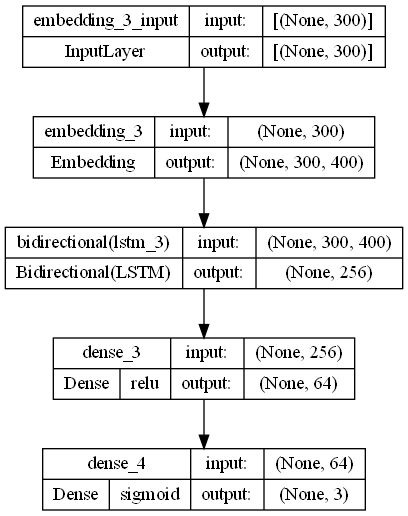

In [45]:
tf.keras.utils.plot_model(model_Bi_LSTM, to_file='model_Bi_LSTM.png', show_shapes=True, show_layer_activations=True)

In [46]:
score = model_Bi_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_Bi_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_Bi_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 153s 315ms/step - loss: 1.1798 - acc: 0.7387
loss: 1.18
acc: 73.87%


In [47]:
preds = model_Bi_LSTM.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 148s 302ms/step


array([0.62596948, 0.23955172, 0.85210835])

## Bi LSTM Attention

In [35]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [48]:
sequence_length = sub_data.shape[1]
drop = 0.1

inputs = Input(shape = (sequence_length,))
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix])(inputs)
bilstm = Bidirectional(LSTM(128, return_sequences = True))(embedding)
attention_layer = attention()(bilstm)
output = Dense(units = 3, activation = 'softmax')(attention_layer)

model_bi_lstm_att = Model(inputs, output)

In [49]:
# Retrieve the config
config = model_bi_lstm_att.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": attention}
with keras.utils.custom_object_scope(custom_objects):
    new_model_bi_lstm_att = keras.Model.from_config(config)
    
new_model_bi_lstm_att.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

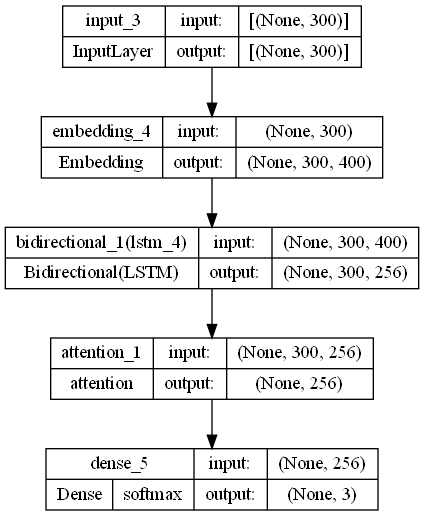

In [50]:
tf.keras.utils.plot_model(new_model_bi_lstm_att, to_file='model_bi_lstm_att.png', show_shapes=True, show_layer_activations=True)

In [51]:
%%time
new_model_bi_lstm_att.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 307s 8s/step - loss: 1.0874 - acc: 0.3766 - val_loss: 1.0012 - val_acc: 0.7262
Epoch 2/100
36/36 [==============================] - 320s 9s/step - loss: 0.9514 - acc: 0.5288 - val_loss: 0.7931 - val_acc: 0.7430
Epoch 3/100
36/36 [==============================] - 319s 9s/step - loss: 0.7478 - acc: 0.6567 - val_loss: 0.6083 - val_acc: 0.7906
Epoch 4/100
36/36 [==============================] - 323s 9s/step - loss: 0.6351 - acc: 0.7292 - val_loss: 0.4237 - val_acc: 0.8306
Epoch 5/100
36/36 [==============================] - 318s 9s/step - loss: 0.5862 - acc: 0.7596 - val_loss: 0.5194 - val_acc: 0.8045
Epoch 6/100
36/36 [==============================] - 317s 9s/step - loss: 0.4939 - acc: 0.8076 - val_loss: 0.7120 - val_acc: 0.7768
Epoch 7/100
36/36 [==============================] - 321s 9s/step - loss: 0.4299 - acc: 0.8416 - val_loss: 0.5712 - val_acc: 0.8031
Epoch 8/100
36/36 [==============================] - 323s 9s/step - loss: 0.

In [52]:
score = new_model_bi_lstm_att.evaluate(data_test, labels_test)

print("%s: %.2f" %(new_model_bi_lstm_att.metrics_names[0], score[0]))
print("%s: %.2f%%" %(new_model_bi_lstm_att.metrics_names[1], score[1]*100))

486/486 [==============================] - 180s 371ms/step - loss: 0.9621 - acc: 0.7649
loss: 0.96
acc: 76.49%


In [53]:
prediction = new_model_bi_lstm_att.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 1s 1s/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [54]:
preds = new_model_bi_lstm_att.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 190s 391ms/step


array([0.6455317 , 0.25960061, 0.87067552])

## CNN

In [55]:

model_CNN = Sequential()
model_CNN.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN.add(Dropout(0.1))
model_CNN.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN.add(MaxPooling1D())
model_CNN.add(Dropout(0.1))
model_CNN.add(Flatten())
model_CNN.add(Dense(units = 3, activation = 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_CNN. summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 400)          4000000   
                                                                 
 dropout (Dropout)           (None, 300, 400)          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 32)           38432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 32)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 150, 32)           0         
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                      

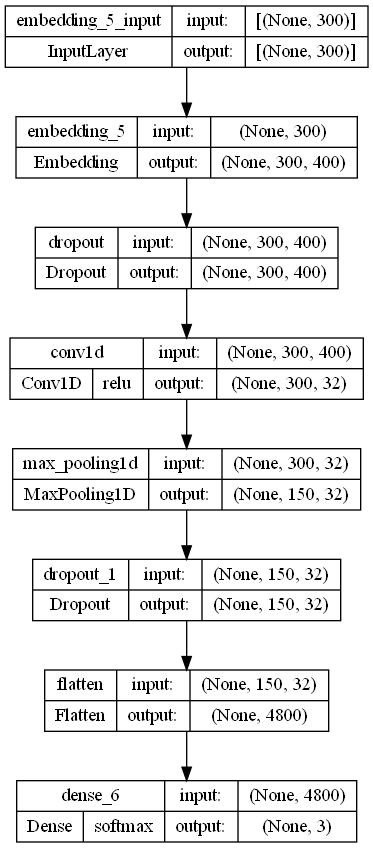

In [56]:
tf.keras.utils.plot_model(model_CNN, to_file='model_CNN.png', show_shapes=True, show_layer_activations=True)

In [57]:
%%time
model_CNN.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 35s 957ms/step - loss: 1.0468 - accuracy: 0.4391 - val_loss: 0.8970 - val_accuracy: 0.7212
Epoch 2/100
36/36 [==============================] - 33s 916ms/step - loss: 0.8039 - accuracy: 0.6266 - val_loss: 0.7105 - val_accuracy: 0.7276
Epoch 3/100
36/36 [==============================] - 35s 966ms/step - loss: 0.6225 - accuracy: 0.7303 - val_loss: 0.6266 - val_accuracy: 0.7749
Epoch 4/100
36/36 [==============================] - 34s 961ms/step - loss: 0.5045 - accuracy: 0.8027 - val_loss: 0.6044 - val_accuracy: 0.7880
Epoch 5/100
36/36 [==============================] - 38s 1s/step - loss: 0.4131 - accuracy: 0.8498 - val_loss: 0.6018 - val_accuracy: 0.7932
Epoch 6/100
36/36 [==============================] - 38s 1s/step - loss: 0.3355 - accuracy: 0.8816 - val_loss: 0.6325 - val_accuracy: 0.7934
Epoch 7/100
36/36 [==============================] - 34s 954ms/step - loss: 0.2834 - accuracy: 0.9068 - val_loss: 0.6677 - val_accuracy: 0.789

In [58]:
score = model_CNN.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN.metrics_names[1], score[1]*100))

486/486 [==============================] - 6s 12ms/step - loss: 1.0194 - accuracy: 0.7607
loss: 1.02
accuracy: 76.07%


In [59]:
prediction = model_CNN.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 64ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [60]:
preds = model_CNN.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 6s 12ms/step


array([0.64894902, 0.26484018, 0.86568461])

## CNN valid padding

In [61]:

model_CNN_valid = Sequential()
model_CNN_valid.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_valid.add(Dropout(0.1))
model_CNN_valid.add(Conv1D(filters=32, kernel_size=3, padding="valid", activation="relu"))
model_CNN_valid.add(MaxPooling1D())
model_CNN_valid.add(Dropout(0.1))
model_CNN_valid.add(Flatten())
model_CNN_valid.add(Dense(units = 3, activation = 'softmax'))

model_CNN_valid.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [62]:
%%time
model_CNN_valid.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 35s 945ms/step - loss: 1.0536 - accuracy: 0.4202 - val_loss: 0.9992 - val_accuracy: 0.6080
Epoch 2/100
36/36 [==============================] - 34s 958ms/step - loss: 0.8361 - accuracy: 0.6124 - val_loss: 0.6770 - val_accuracy: 0.7880
Epoch 3/100
36/36 [==============================] - 39s 1s/step - loss: 0.6258 - accuracy: 0.7304 - val_loss: 0.6122 - val_accuracy: 0.7789
Epoch 4/100
36/36 [==============================] - 35s 967ms/step - loss: 0.4885 - accuracy: 0.8069 - val_loss: 0.6240 - val_accuracy: 0.7777
Epoch 5/100
36/36 [==============================] - 33s 915ms/step - loss: 0.3975 - accuracy: 0.8511 - val_loss: 0.6014 - val_accuracy: 0.7896
Epoch 6/100
36/36 [==============================] - 42s 1s/step - loss: 0.3270 - accuracy: 0.8847 - val_loss: 0.6370 - val_accuracy: 0.7951
Epoch 7/100
36/36 [==============================] - 42s 1s/step - loss: 0.2728 - accuracy: 0.9109 - val_loss: 0.7505 - val_accuracy: 0.7605
E

In [63]:
score = model_CNN_valid.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_valid.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_valid.metrics_names[1], score[1]*100))

486/486 [==============================] - 7s 14ms/step - loss: 1.0466 - accuracy: 0.7385
loss: 1.05
accuracy: 73.85%


## CNN causal padding

In [64]:

model_CNN_causal = Sequential()
model_CNN_causal.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_causal.add(Dropout(0.1))
model_CNN_causal.add(Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu"))
model_CNN_causal.add(MaxPooling1D())
model_CNN_causal.add(Dropout(0.1))
model_CNN_causal.add(Flatten())
model_CNN_causal.add(Dense(units = 3, activation = 'softmax'))

model_CNN_causal.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [65]:
%%time
model_CNN_causal.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 47s 1s/step - loss: 1.0583 - accuracy: 0.4246 - val_loss: 0.9548 - val_accuracy: 0.6489
Epoch 2/100
36/36 [==============================] - 43s 1s/step - loss: 0.8352 - accuracy: 0.6090 - val_loss: 0.7048 - val_accuracy: 0.7457
Epoch 3/100
36/36 [==============================] - 39s 1s/step - loss: 0.6283 - accuracy: 0.7376 - val_loss: 0.6127 - val_accuracy: 0.7850
Epoch 4/100
36/36 [==============================] - 39s 1s/step - loss: 0.4958 - accuracy: 0.8053 - val_loss: 0.5813 - val_accuracy: 0.8007
Epoch 5/100
36/36 [==============================] - 40s 1s/step - loss: 0.4017 - accuracy: 0.8470 - val_loss: 0.6506 - val_accuracy: 0.7792
Epoch 6/100
36/36 [==============================] - 42s 1s/step - loss: 0.3283 - accuracy: 0.8844 - val_loss: 0.6503 - val_accuracy: 0.7893
Epoch 7/100
36/36 [==============================] - 44s 1s/step - loss: 0.2694 - accuracy: 0.9067 - val_loss: 0.7953 - val_accuracy: 0.7531
Epoch 8/100
3

In [ ]:
score = model_CNN_causal.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_causal.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_causal.metrics_names[1], score[1]*100))

486/486 [==============================] - 8s 17ms/step - loss: 1.2753 - accuracy: 0.7302
loss: 1.28
accuracy: 73.02%


## CNN + LSTM tuần tự

In [ ]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN_LSTM.add(MaxPooling1D())
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(LSTM(units=32,  dropout=drop, return_sequences = True))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(units = 3, activation = 'softmax'))

adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model_CNN_LSTM.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_CNN_LSTM. summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 400)          4000000   
                                                                 
 dropout_6 (Dropout)         (None, 300, 400)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 300, 32)           38432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 150, 32)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 150, 32)           0         
                                                                 
 lstm_5 (LSTM)               (None, 150, 32)           8320      
                                                      

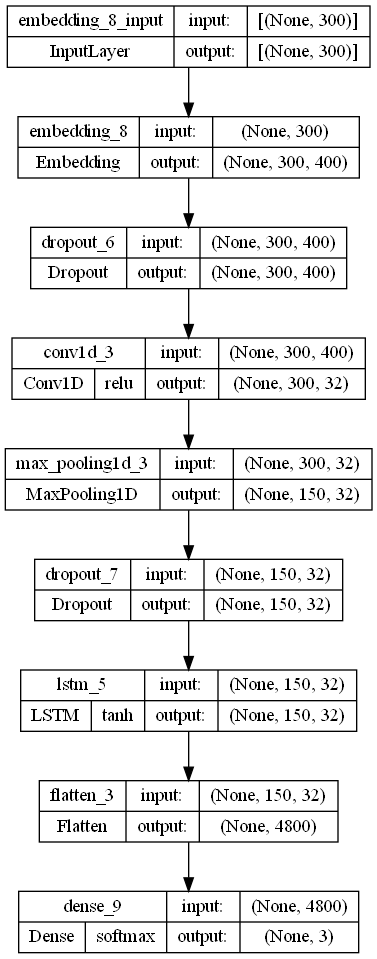

In [ ]:
tf.keras.utils.plot_model(model_CNN_LSTM, to_file='model_CNN_LSTM.png', show_shapes=True, show_layer_activations=True)

In [ ]:
%%time
model_CNN_LSTM.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 46s 1s/step - loss: 1.0359 - accuracy: 0.4412 - val_loss: 0.8670 - val_accuracy: 0.7254
Epoch 2/100
36/36 [==============================] - 42s 1s/step - loss: 0.7898 - accuracy: 0.6222 - val_loss: 0.6025 - val_accuracy: 0.8092
Epoch 3/100
36/36 [==============================] - 43s 1s/step - loss: 0.6288 - accuracy: 0.7251 - val_loss: 0.6684 - val_accuracy: 0.7782
Epoch 4/100
36/36 [==============================] - 46s 1s/step - loss: 0.5158 - accuracy: 0.7869 - val_loss: 0.6839 - val_accuracy: 0.7838
Epoch 5/100
36/36 [==============================] - 43s 1s/step - loss: 0.4277 - accuracy: 0.8379 - val_loss: 0.6321 - val_accuracy: 0.8018
Epoch 6/100
36/36 [==============================] - 43s 1s/step - loss: 0.3613 - accuracy: 0.8653 - val_loss: 0.7252 - val_accuracy: 0.7951
Epoch 7/100
36/36 [==============================] - 47s 1s/step - loss: 0.3062 - accuracy: 0.8890 - val_loss: 0.8969 - val_accuracy: 0.7672
Epoch 8/100
3

In [ ]:
score = model_CNN_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 11s 22ms/step - loss: 1.3027 - accuracy: 0.7473
loss: 1.30
accuracy: 74.73%


In [ ]:
prediction = model_CNN_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 460ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


In [ ]:
preds = model_CNN_LSTM.predict(data_test)
preds_class = np.argmax(preds, axis = 1)
f1_score(test_class, preds_class, average=None)

486/486 [==============================] - 11s 22ms/step


array([0.65401385, 0.25728044, 0.85688009])